In [1]:
# download("https://raw.githubusercontent.com/neubig/nn4nlp-code/master/data/tags/train.txt", "train.txt")

In [2]:
# download("https://raw.githubusercontent.com/neubig/nn4nlp-code/master/data/tags/dev.txt", "dev.txt")

In [3]:
# using Pkg;Pkg.add("DataStructures")
# Pkg.add("Dates")
# Pkg.add("StatsBase")

In [1]:
using Knet: KnetArray,Knet, AutoGrad, param, param0, mat, RNN, relu, Data, adam, progress, nll, zeroone, logp, softmax
using DataStructures: DefaultDict
using IterTools: ncycle, takenth
using Random:randsubseq
using Random
using StatsBase
using Dates
using Random: shuffle!
using Base.Iterators: flatten

┌ Warning: Hardware is unsupported by NNPACK so falling back to default NNlib
└ @ NNlib /kuacc/users/aalabrash18/.julia/packages/NNlib/Nksco/src/nnpack/NNPACK.jl:49


In [2]:
NXENT = 40
NXER = 20
delta = 2
EMBED_SIZE = 64
HIDDEN_SIZE = 128

128

In [3]:
w2i=Dict()
t2i=Dict()
function read_file(fname)
    input_file= readlines(fname)
    results=[]
    for row in input_file
        #@show split(row)
        words, tags = Array{Int32,1}(), Array{Int32,1}()
        for wt in split(strip(row))
            w,t=split(strip(wt),"|")
         #   @show w,t
            get!(w2i,w,length(w2i)+1)
             push!(words,w2i[w])
            get!(t2i,t,length(t2i)+1)
             push!(tags,t2i[t])
        end
        push!(results,(words,tags))
    end
    results
end

read_file (generic function with 1 method)

In [4]:
train = read_file("train.txt")
unk_word = get!(w2i,"<unk>",length(w2i)+1)
unk_tag =  get!(t2i,"<unk>",length(t2i)+1)
nwords = length(w2i)

words=keys(w2i)
allw_i=Array{Int64}(collect(values(w2i)))
tags=keys(t2i)
allt_i=Array{Int64}(collect(values(t2i)));
ntags = length(t2i)

dev = read_file("dev.txt");

In [5]:
struct Embed; w; end
function Embed(vocabsize::Int, embedsize::Int)
    # Your code here
    Embed(param(embedsize, vocabsize, atype = KnetArray{Float32}))
end
function (l::Embed)(x)
    # Your code here
    l.w[:,x]
end
struct Dense; w; b; f; end
Dense(i::Int,o::Int,f=identity) = Dense(param(o,i), param0(o), f)
(d::Dense)(x) = d.f.(d.w * mat(x,dims=1) .+ d.b)


In [6]:
#supervision
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)
(c::Chain)(x,y) = nll(c(x),y)

In [7]:
#RL 
struct Chain2
    layers
    Chain2(layers...) = new(layers)
end
##
(c::Chain2)(x) = (for i in 1:length(c.layers)-2; x = c.layers[i](x); end; x)
(c::Chain2)(x,y) = RL_nll(c(x), y)#nll(c(x),y) 
##after calculating the nll(probs=true)-> sample over the index -> calcuate the rewards -> 

In [8]:
function trainresults(file,maker,savemodel)
    if (print("Train from scratch? "); readline()[1]=='y')
        model = maker()
        results = ((nll(model,dev), zeroone(model,dev))
                   for x in takenth(progress(adam(model,ncycle(train,20))),700))#500
        results = reshape(collect(Float32,flatten(results)),(2,:))
        Knet.save(file,"model",(savemodel ? model : nothing),"results",results)
        Knet.gc() # To save gpu memory
    else
        isfile(file) || download("http://people.csail.mit.edu/deniz/models/tutorial/$file",file)
        model,results = Knet.load(file,"model","results")
    end
    println(minimum(results,dims=2))
    return model,results
end

trainresults (generic function with 1 method)

In [306]:
Tagger_Supervision(vocab,embed,hidden,output)=Chain(
    Embed(vocab,embed),
    RNN(embed,hidden,rnnType=:relu,bidirectional=true),
    Dense(2hidden,output))
supervison() = Tagger_Supervision(length(w2i),EMBED_SIZE,HIDDEN_SIZE,ntags)
(supervision_model,results_model) = trainresults("tagger113a.jld2",supervison,true)

Train from scratch? stdin> n
Float32[0.37268925; 0.11792755]


(Chain((Embed(P(KnetArray{Float32,2}(64,29002))), RNNRELU(input=64,hidden=128,bidirectional), Dense(P(KnetArray{Float32,2}(10,256)), P(KnetArray{Float32,1}(10)), identity))), Float32[0.5656022 0.52369183 … 0.5997244 0.55756307; 0.16332966 0.1606891 … 0.14010306 0.13046376])

In [307]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

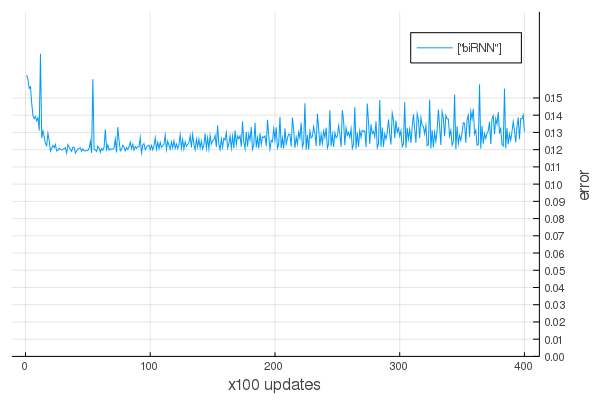

In [308]:
plot(results_model[2,:], xlabel="x100 updates", ylabel="error",
    ylim=(0,0.2), yticks=0:0.01:0.15, labels=["biRNN"])

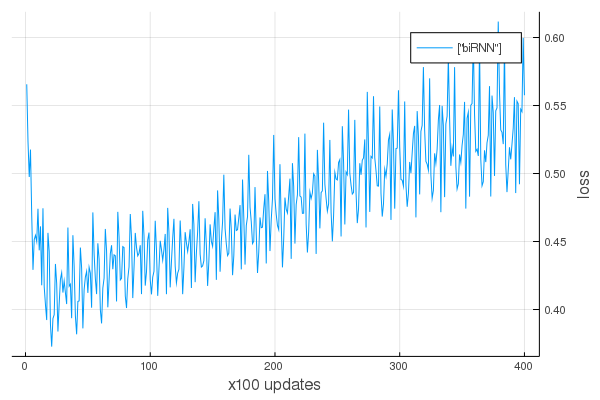

In [309]:
plot(results_model[1,:], xlabel="x100 updates", ylabel="loss",
    labels=["biRNN"])

In [310]:
EMB,LSTM_RNN,DENSE=supervision_model.layers

(Embed(P(KnetArray{Float32,2}(64,29002))), RNNRELU(input=64,hidden=128,bidirectional), Dense(P(KnetArray{Float32,2}(10,256)), P(KnetArray{Float32,1}(10)), identity))

In [314]:
Tagger_RL(Embed_layer, Rnn, Rnn_d,hidden)=Chain2(
    Embed_layer,
    Rnn,
    Rnn_d, 
    Dense(2hidden,1))
RL() = Tagger_RL(EMB, LSTM_RNN, DENSE,HIDDEN_SIZE)
RL2 = RL()

Chain2((Embed(P(KnetArray{Float32,2}(64,29002))), RNNRELU(input=64,hidden=128,bidirectional), Dense(P(KnetArray{Float32,2}(10,256)), P(KnetArray{Float32,1}(10)), identity), Dense(P(KnetArray{Float32,2}(1,256)), P(KnetArray{Float32,1}(1)), identity)))

In [315]:
function RL_nll(scores_rnn, tags) 
    scores_rnn_per = permutedims(scores_rnn)
    # Do forward pass over the RNN_D layer.
    RNN_D = RL2.layers[length(RL2.layers)-1]
    scores = RNN_D(scores_rnn)
    
    losses,_ = nll(scores, tags; average = false)
    scores_per = permutedims(scores)
    probs = softmax(scores_per; dims = 2)
    ####
    losses= []
    for i in 1:size(scores_per)[1]
        loss,_ = nll(scores_per[i,:], [tags[i]], average = false)
        push!(losses, loss)
    end
    ####
    
    # Sample.
    samples = []
    for i in 1:size(probs)[1]
        sam = sample(collect(1:length(probs[1,:])), Weights(value(Array(probs[i,:]))))#Weights(Array(probs[i,:])))
        push!(samples, sam)
    end
    # Calculate accuracy
#     correct = 0
#     for i in 1:length(tags)
#         if tags[i] == samples[i]
#             correct += 1
#         end
#     end
    
#     correct=sum(tags.==sampeles)
#     r = correct  /  length(tags)
    r=sum(tags.==samples) /  length(tags)
    r_a = KnetArray{Float32}([Float32(r)])
    r_a = reshape(r_a,  (1,1))
    
    # Do forward pass over the Reward Dense. 
    RL_layer = RL2.layers[length(RL2.layers)]
    r_b = []
    for i in 1:size(scores_rnn_per)[1]
        r_i = RL_layer(scores_rnn_per[i,:])
        push!(r_b, r_i)
    end
    rewards_over_baseline = [r_a - x for x in r_b]
    
    baseline_scores = [(r_a-x)*(r_a-x) for x in r_b]
    
     reinforce_scores = []
     for i in 1:size(scores_per)[1]
         re_s = losses[i]*value(rewards_over_baseline[i])
         push!(reinforce_scores, re_s)
     end
    
    #reinforce_scores=scores_per.* value(rewards_over_baseline)
   
    base_sum = sum(baseline_scores); 
    mixer_sum = sum(reinforce_scores);
    return mixer_sum[1], base_sum[1]
end

RL_nll (generic function with 1 method)

In [316]:
using Knet

In [317]:
@doc nll

```
nll(scores, answers; dims=1, average=true)
```

Given an unnormalized `scores` matrix and an `Integer` array of correct `answers`, return the negative log likelihood. The `scores` matrix should have size (classes,instances) if `dims=1` or (instances,classes) if `dims=2`. `answers[i]` should be in `1:classes` to indicate the correct class for instance i, or 0 to skip instance i. The return value is `(total/count)` if `average=true` and `(total,count)` if `average=false` where `count` is the number of instances not skipped and `total` is their total negative log likelihood.

```
nll(model, data; dims=1, average=true, o...)
```

Compute negative log likelihood `nll(model(x; o...), y; dims)` for `(x,y)` in `data` and return `(total/count)` if `average=true` or `(total,count)` if `average=false`.


In [318]:
@diff RL2(train[2][1],train[2][2])[1]

T(0.13832766)

In [319]:
old_wieghts=deepcopy(params(RL2))

6-element Array{Param,1}:
 P(KnetArray{Float32,2}(64,29002)) 
 P(KnetArray{Float32,3}(1,1,49664))
 P(KnetArray{Float32,2}(10,256))   
 P(KnetArray{Float32,1}(10))       
 P(KnetArray{Float32,2}(1,256))    
 P(KnetArray{Float32,1}(1))        

In [320]:
function model_forward(sent)
    RL2.layers[length(RL2.layers)-1](RL2(sent))
end

model_forward (generic function with 1 method)

In [321]:
lr=0.0001; gclip=0; beta1=0.9; beta2=0.999; eps=1e-8;t=0
#adam
# v = beta1 * v + (1 - beta1) * g
# G = beta2 * G + (1 - beta2) * g .^ 2
# vhat = v ./ (1 - beta1 ^ t)
# Ghat = G ./ (1 - beta2 ^ t)
# w = w - (lr / (sqrt(Ghat) + eps)) * vhat


#sgd
# w .= w - lr * g

0

In [322]:
#TODO change SGD to adam optimizer
function optimize(model,train; lr=0.0001,nextprint=10,epoch=1)
    w1 = params(model)[[1,2,3,4]]
    w2 = params(model)[[5,6]]
    for ep in 1:epoch
        iters = length(train)
        for t = 1:iters
            L1 = @diff model(train[t][1], train[t][2])[1]
            L2 = @diff model(train[t][1], train[t][2])[2]
            if t % 1000 == 0
               println("Iter: ", t) 
            end
            for i in 1:length(w1)
                ∇wi = grad(L1,w1[i])
                if ∇wi != nothing;
                     w1[i] .-= lr * AutoGrad.full(∇wi);
                        #v = beta1 * v + (1 - beta1) * AutoGrad.full(∇wi);
                        #G = beta2 * G + (1 - beta2) * AutoGrad.full(∇wi); #.^ 2
                        #vhat = v ./ (1 - beta1 ^ t)
                        #Ghat = G ./ (1 - beta2 ^ t)
                        #w1[i] = w1[i] - (lr / (sqrt(Ghat) + eps)) * vhat
                end
            end
        
            for i in 1:length(w2)
                ∇wi2 = grad(L2,w2[i])
                if ∇wi2 != nothing;
                    w2[i] .-= lr * AutoGrad.full(∇wi2);
                        #v2 = beta1 * v2 + (1 - beta1) * AutoGrad.full(∇wi2);
                        #G_2 = beta2 * G_2 + (1 - beta2) * AutoGrad.full(∇wi2); #.^ 2
                        #vhat_2 = v2 ./ (1 - beta1 ^ t)
                        #Ghat_2 = G_2 ./ (1 - beta2 ^ t)
                        #w2[i] = w2[i] - (lr / (sqrt(Ghat_2) + eps)) * vhat_2
                end
            end
        end  
           println((epoch=ep, error=zeroone(model_forward,dev)))
    end
    #w1,w2
end

optimize (generic function with 1 method)

In [323]:
optimize(RL2, train;nextprint=length(train),epoch=20)

Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 1, error = 0.1304381264901172)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 2, error = 0.1315404927320737)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 3, error = 0.13074576358089574)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 4, error = 0.131694311277463)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 5, error = 0.13254031327710414)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter: 9000
Iter: 10000
(epoch = 6, error = 0.13220703976209403)
Iter: 1000
Iter: 2000
Iter: 3000
Iter: 4000
Iter: 5000
Iter: 6000
Iter: 7000
Iter: 8000
Iter